![GAN images](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Example-of-Photorealistic-Generated-Faces-using-Progressive-Growing-GAN.png)
# Generative Adversarial Networks

Estamos acostumados a lidar  com redes de classificação, que aprendem a reconhecer pessoas, objetos, animais, entre outros. Porém, há uma outra classe de redes capazes de gerar coisas novas, as chamadas redes generativas.

Dentro dessa classe de redes generativas, iremos explorar um tipo específico, as GANs (Generative Adversarial Networks)


## O que é uma GAN?

Uma GAN é um modelo capaz de gerar imagens falsas que se assemelham a imagens reais, para exemplos de imagens geradas, há a imagem no inicio do notebook, onde podemos ver várias pessoas que não existem, criadas por uma rede.
Para ver mais, você pode acessar este site https://thispersondoesnotexist.com/, cada vez que o site é recarregado, uma nova pessoa falsa gerada por rede é mostrada. 


O modelo é composto por 2 redes, uma rede chamada de **geradora** e outra chamada de **discriminadora**, a rede geradora é responsável por criar imagens falsas, enquanto a discriminadora deve ser treinada para distinguir as imagens falsas criadas pela geradora das imagens reais do banco de imagens utilizados.

O banco de imagens selecionado deverá refletir o tipo de imagem falsa que se deseja criar, pois a geradora irá tentar criar imagens parecidas com as do banco para enganar a rede discriminadora.

As GANs não servem somente para imagens, mas é o exemplo mais comum e o que será explorado neste notebook.

## Estrutura da GAN
Para realizar o treinamento da GAN, fazemos o seguinte esquema:

![Estrutura](https://i.ibb.co/ZXXjTCg/GAN.png)

A rede geradora recebe ruído de entrada (vetores com numeros aleatórios, obtidos de uma distribuição normal) e, a partir deles, irá gerar imagens falsas. Inicialmente, essas imagens falsas serão apenas ruído, pois a rede geradora ainda não terá aprendido nada.

Em seguida, passamos as imagens reais e as imagens falsas para a rede discriminadora e obtemos predições sobre quais são reais e quais são falsas.

Para treinar as redes, colocaremos ela para fazer uma disputa sobre a função de valor $V$ dada pela seguinte expressão:

$$\underset{G}{\text{min}} \ \underset{D}{\text{max}} \ V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[log \ D(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]$$

Onde a rede geradora tenta minimizar a função e a rede discriminadora tenta maximizá-la

Para entender a expressão, olhe pelo ponto de vista de cada rede. A rede geradora quer enganar a discriminadora, portanto ela almeja que $D(G(z))$ (a predição da discriminadora sobre uma imagem falsa) seja 1, portanto, o objetivo dela é minimizar $log(1-D(G(z)))$. Já a rede discriminadora almeja fazer $D(x)$ (a predição sobre uma imagem real) ser 1, portanto almeja maximizar $log \ D(x)$, além disso, ela também precisa identificar as imagens falsas, fazendo $D(G(z))$ ser 0, portanto maximizando $log(1-D(G(z)))$.

# Implementação

Iremos realizar uma implementação em PyTorch utilizando o subconjunto de carros do dataset CIFAR-10.

Pytorch: https://pytorch.org/
CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html

Imagens do CIFAR-10:

<img src="https://i1.wp.com/www.dobitaobyte.com.br/wp-content/uploads/2018/12/cifar-10.png?ssl=1" width="500"/>

In [1]:
# Import das bibiliotecas
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

# Estrutura convolucional para uma GAN

Há várias maneiras de se criar as redes discriminadora e a geradora, neste notebook iremos fazer uma **discriminadora convolucional** e uma **geradora deconvolucional**.


## Rede Discriminadora
A rede discriminadora é constituída de 4 camadas de convolução e camadas de **BatchNorm**, com ativação **sigmoid** na última camada e **relu** nas restantes.

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 512, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2 = nn.Conv2d(512, 256, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 128, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 1, 4, 1, 0)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), inplace=True, negative_slope=0.2)
        x = self.bn1(x)
        x = F.leaky_relu(self.conv2(x), inplace=True, negative_slope=0.2)
        x = self.bn2(x)
        x = F.leaky_relu(self.conv3(x), inplace=True, negative_slope=0.2)
        x = self.bn3(x)
        x = torch.sigmoid(self.conv4(x))
        return x

## Rede Geradora
A rede geradora é constituída de 4 camadas de deconvolução (operação inversa da convolução), com camadas de **BatchNorm**, com ativação **tanh** na última camada e **relu** nas restantes.

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.convt1 = nn.ConvTranspose2d(100, 1024, 4, 1, 0)
        self.bn1 = nn.BatchNorm2d(1024)
        self.convt2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.bn2 = nn.BatchNorm2d(512)
        self.convt3 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.bn3 = nn.BatchNorm2d(256)
        self.convt4 = nn.ConvTranspose2d(256, 3, 4, 2, 1)


    def forward(self, x):
        x = F.relu(self.convt1(x), inplace=True)
        x = self.bn1(x)
        x = F.relu(self.convt2(x), inplace=True)
        x = self.bn2(x)
        x = F.relu(self.convt3(x), inplace=True)
        x = self.bn3(x)
        x = torch.tanh(self.convt4(x))
        return x

## Inicialização dos pesos das redes
Como dito neste artigo do site da biblioteca Pytorch - https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html - precisamos inicializar os pesos
de uma maneira específica, seguindo uma distribuição padrão com média 0 e desvio padrão 0.02, para auxiliar na convergência da rede, o que pode ser feito com a seguinte função:

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Importando o dataset
Iremos importar apenas os carros do CIFAR-10 em um dataloader

In [5]:
batch_size = 10
to_tensor = torchvision.transforms.ToTensor()
training_data = datasets.CIFAR10(root='./dataset', train=True, download=True,transform=to_tensor)

# Função para selecionar apenas uma classe do CIFAR-10
def get_indices(dataset, class_name):
    indices =  []
    for i in range(len(dataset.targets)):
        if dataset.targets[i] == class_name:
            indices.append(i)
    return indices

# Selecionando a classe de carros
idx = get_indices(training_data, 1)

training_dataloader = torch.utils.data.DataLoader(training_data,
                                                  batch_size=batch_size,
                                                  num_workers=4,
                                                  pin_memory=True,
                                                  sampler=torch.utils.data.sampler.SubsetRandomSampler(idx))

Extracting ./dataset/cifar-10-python.tar.gz to ./dataset


# Treinamento

In [6]:
# Instanciação das redes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
discriminator = Discriminator().to(device)
generator = Generator().to(device)

# Inicialização dos pesos
discriminator.apply(weights_init)
generator.apply(weights_init)


# Vamos utilizar otimizadores Adam
discriminator_optim = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
generator_optim = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# A função de custo será a BCELoss, que permite calcular as duas componentes
# da função de valor comentada anteriormente
criterion = nn.BCELoss()

# Guardaremos os erros para fazer um gráfico posteriormente
D_losses = []
G_losses = []

epochs = 50
total = len(idx)
for i in range(epochs):
    # Variáveis para imprimir a porcentagem do treino que já foi realizada
    current = 0
    count = 0
    
    for batch, _ in training_dataloader:
        # Começamos passando um batch de imagens reais para a discriminadora
        # e a atualizamos
        labels = torch.ones((batch_size, ), device=device)

        discriminator_optim.zero_grad()
        real_x = batch.to(device)
        real_y = discriminator(real_x).view(-1)
        real_loss = criterion(real_y, labels)
        real_loss.backward()
        
        # Em seguida passamos um batch falso para a discriminadora
        # e a atualizamos
        labels.fill_(0)
        generator_x = torch.randn((batch_size, 100, 1, 1), device=device)
        fake_x = generator(generator_x)
        fake_y_D = discriminator(fake_x.detach()).view(-1)
        fake_loss_D = criterion(fake_y_D, labels)
        fake_loss_D.backward()
        discriminator_optim.step()
        D_losses.append(real_loss+fake_loss_D)

        # Finalmente, calculamos o erro da geradora e a atualizamos
        labels.fill_(1)
        generator_optim.zero_grad()
        fake_y_G = discriminator(fake_x).view(-1)
        fake_loss_G = criterion(fake_y_G, labels)
        fake_loss_G.backward()
        generator_optim.step()
        G_losses.append(fake_loss_G)

        if not (count % 100):
            print(f"Epoch {i}: percentage: {100*current/total}% | D loss: {real_loss+fake_loss_D:.5f} | G loss: {fake_loss_G:.5f}")
        current += len(batch)
        count += 1
    print(f"Epoch {i}: percentage: 100%")

Epoch 0: percentage: 0.0% | D loss: 1.64253 | G loss: 3.65948
Epoch 0: percentage: 20.0% | D loss: 0.45936 | G loss: 5.49986
Epoch 0: percentage: 40.0% | D loss: 0.12079 | G loss: 4.86768
Epoch 0: percentage: 60.0% | D loss: 0.10591 | G loss: 5.45931
Epoch 0: percentage: 80.0% | D loss: 0.01768 | G loss: 5.97116
Epoch 0: percentage: 100%
Epoch 1: percentage: 0.0% | D loss: 0.01967 | G loss: 6.96899
Epoch 1: percentage: 20.0% | D loss: 0.02006 | G loss: 5.99142
Epoch 1: percentage: 40.0% | D loss: 0.00419 | G loss: 6.34690
Epoch 1: percentage: 60.0% | D loss: 0.00557 | G loss: 6.23920
Epoch 1: percentage: 80.0% | D loss: 0.00811 | G loss: 5.74834
Epoch 1: percentage: 100%
Epoch 2: percentage: 0.0% | D loss: 0.00662 | G loss: 5.72072
Epoch 2: percentage: 20.0% | D loss: 0.00061 | G loss: 10.98962
Epoch 2: percentage: 40.0% | D loss: 0.68692 | G loss: 1.81572
Epoch 2: percentage: 60.0% | D loss: 0.86951 | G loss: 2.16452
Epoch 2: percentage: 80.0% | D loss: 0.37035 | G loss: 2.71560
Epoch

In [7]:
# Salvamos as redes para uso posterior
torch.save(discriminator.state_dict(), "discriminator")
torch.save(generator.state_dict(), "generator")

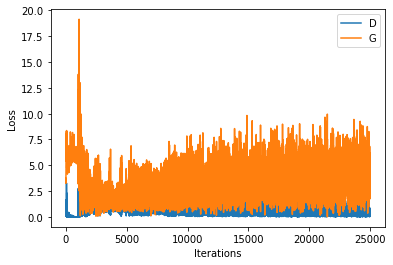

In [8]:
# Plot dos erros
plt.plot(D_losses, label="D")
plt.plot(G_losses, label="G")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.legend()
plt.show()

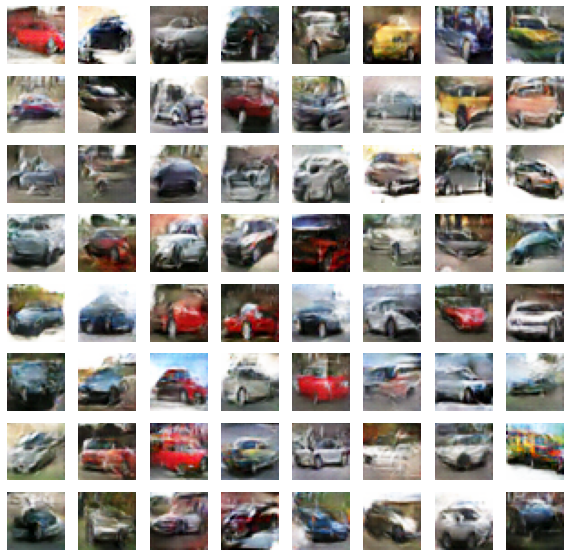

In [9]:
# Agora faremos um plot com imagens falsas geradas
# para ver o resultado

n = 8
fig, ax = plt.subplots(n, n, figsize=(10, 10))
images = generator(torch.randn((n*n, 100, 1, 1), device=device))
for i in range(len(images)):
    image = images[i].detach().cpu().numpy()
    ax[i//n][i%n].imshow(np.clip(image.transpose(1, 2, 0), 0, 1))
    ax[i//n][i%n].axis('off')
plt.show()